# <font style="color:blue">Project 2: Kaggle Competition - Classification</font>

#### Maximum Points: 100

<div>
    <table>
        <tr><td><h3>Sr. no.</h3></td> <td><h3>Section</h3></td> <td><h3>Points</h3></td> </tr>
        <tr><td><h3>1</h3></td> <td><h3>Data Loader</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>2</h3></td> <td><h3>Configuration</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>3</h3></td> <td><h3>Evaluation Metric</h3></td> <td><h3>10</h3></td> </tr>
        <tr><td><h3>4</h3></td> <td><h3>Train and Validation</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>5</h3></td> <td><h3>Model</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>6</h3></td> <td><h3>Utils</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>7</h3></td> <td><h3>Experiment</h3></td><td><h3>5</h3></td> </tr>
        <tr><td><h3>8</h3></td> <td><h3>TensorBoard Dev Scalars Log Link</h3></td> <td><h3>5</h3></td> </tr>
        <tr><td><h3>9</h3></td> <td><h3>Kaggle Profile Link</h3></td> <td><h3>50</h3></td> </tr>
    </table>
</div>


## <font style="color:green">1. Data Loader [10 Points]</font>

In this section, you have to write a class or methods that will be used to get training and validation data
loader.

You will have to write a custom dataset class to load data.

**Note that there are not separate validation data, so you will have to create your validation set by dividing train data into train and validation data. Usually, in practice, we do `80:20` ratio for train and validation, respectively.** 

For example,

```
class KenyanFood13Dataset(Dataset):
    """
    
    """
    
    def __init__(self, *args):
    ....
    ...
    
    def __getitem__(self, idx):
    ...
    ...
    
    
```

```
def get_data(args1, *agrs):
    ....
    ....
    return train_loader, test_loader
```

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [3]:
import os
import time

from typing import Iterable
from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms

from torch.optim import lr_scheduler

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torchvision.transforms.functional as TF
import glob
from PIL import Image
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import CLR as CLR
import OneCycle as OneCycle
from sklearn.utils import class_weight

sz=299

dataset = datasets.ImageFolder(root='/media/hdd/project/opencv/DL/P7_kaggel/data_new/validation/')

y_label=[]
for i in range(len(dataset)):
    _,y = dataset[i]
    y_label.append(y)

class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_label),
                                                 y_label)

class_weights

In [4]:
class_weights_train = np.array([0.79643343, 0.5866637 , 1.04211983, 1.00342727, 2.91643608,
       0.81076923, 1.13235926, 1.00591716, 2.3568873 , 0.65069762,
       1.51262916, 1.30348751, 0.80593363])

class_weights_val = np.array([0.79174484, 0.56950067, 1.08205128, 1.08205128, 2.86425339,
       0.81153846, 1.21730769, 1.21730769, 2.43461538, 0.60487339,
       1.5964691 , 1.07016061, 0.77907692])

In [5]:
class_weights_train_t = torch.tensor(class_weights_train).cuda().float()
class_weights_val_t = torch.tensor(class_weights_val).cuda().float()

In [6]:
def image_preprocess_transforms():
    
    preprocess = transforms.Compose([
        transforms.Resize(sz),
        transforms.CenterCrop(sz),
        transforms.ToTensor()
        ])
    
    return preprocess

In [7]:
def image_common_transforms(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    preprocess = image_preprocess_transforms()
    
    common_transforms = transforms.Compose([
        preprocess,
        transforms.Normalize(mean, std)
    ])
    
    return common_transforms

In [8]:
class testData(Dataset):
    def __init__(self, path, transform=None):
        self.image_paths = glob.glob(path + '*.jpg')
        #self.images = [TF.to_pil_image(x) for x in self.image_paths]
        self.transform = transform
        
    def __getitem__(self, index):
        image =  Image.open(self.image_paths[index])
        
        if self.transform is not None:
            img = self.transform(image)

        return img
        
    def __len__(self):
        return len(self.image_paths)
    
    def __filepath__(self):
        return self.image_paths

In [9]:
def get_mean_std(data_root, num_workers=4):
    
    #transform = image_preprocess_transforms()
    
    #loader = data_loader(data_root, transform)

    mean=[0.485, 0.456, 0.406] 
    std=[0.229, 0.224, 0.225]
    
    #for images, _ in loader:
    #    batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
    #    images = images.view(batch_samples, images.size(1), -1)
    #    mean += images.mean(2).sum(0)
    #    std += images.std(2).sum(0)

    #mean /= len(loader.dataset)
    #std /= len(loader.dataset)
    
    print('mean: {}, std: {}'.format(mean, std))
    
    return mean, std

In [10]:
def data_augmentation_preprocess(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)):
    
    data_augmentation_preprocess_transforms = transforms.Compose([
        transforms.Resize(sz),
        transforms.CenterCrop(sz),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=(-90, 90)),
        transforms.ColorJitter(hue=.05, saturation=.05),
        transforms.RandomVerticalFlip(p=0.5),
        #transforms.Grayscale(3),
        #transforms.RandomGrayscale(p=0.1),
        transforms.RandomAffine(30, translate=None, scale=None, shear=None, resample=False, fillcolor=0),
        transforms.ToTensor(),        
        transforms.Normalize(mean, std)
    ])
    
    return data_augmentation_preprocess_transforms

In [11]:
class MyData(Dataset):
    def __init__(self, path, transform=None):
        self.image_paths = glob.glob(path + '*.jpg')
        #self.images = [TF.to_pil_image(x) for x in self.image_paths]
        self.transform = transform
        
    def __getitem__(self, index):
        image =  Image.open(self.image_paths[index])
        
        if self.transform is not None:
            img = self.transform(image)

        return img
        
    def __len__(self):
        return len(self.image_paths)
    
    def __filepath__(self):
        return self.image_paths

In [12]:
def data_loader(data_root, transform, batch_size=16, shuffle=False, num_workers=2):
    dataset = datasets.ImageFolder(root=data_root, transform=transform)
    
    loader = torch.utils.data.DataLoader(dataset, 
                                         batch_size=batch_size,
                                         num_workers=num_workers,
                                         shuffle=shuffle)
    
    return loader

In [13]:
def get_data(batch_size, data_root, num_workers=4, data_augmentation=False):
    
    train_data_path = os.path.join(data_root, 'training')
       
    mean, std = get_mean_std(data_root=train_data_path, num_workers=num_workers)
    
    common_transforms = image_common_transforms(mean, std)
        
   
    # if data_augmentation is true 
    # data augmentation implementation
    if data_augmentation:    
        train_transforms = data_augmentation_preprocess(mean, std)
    # else do common transforms
    else:
        train_transforms = common_transforms
        
        
    # train dataloader
    
    train_loader = data_loader(train_data_path, 
                               train_transforms, 
                               batch_size=batch_size, 
                               shuffle=True, 
                               num_workers=num_workers)
    
    # test dataloader
    
    test_data_path = os.path.join(data_root, 'validation')
    
    test_loader = data_loader(test_data_path, 
                              common_transforms, 
                              batch_size=batch_size, 
                              shuffle=False, 
                              num_workers=num_workers)
    
    return train_loader, test_loader

In [14]:
def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom

In [15]:
def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

## <font style="color:green">2. Configuration [5 Points]</font>

Define your configuration in this section.

For example,

```
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 10 
    epochs_count: int = 50  
    init_learning_rate: float = 0.1  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = "/kaggle/input/pytorch-opencv-course-classification/" 
    num_workers: int = 2  
    device: str = 'cuda'  
    
```

In [16]:
@dataclass
class SystemConfiguration:
    '''
    Describes the common system setting needed for reproducible training
    '''
    seed: int = 21  # seed number to set the state of all random number generators
    cudnn_benchmark_enabled: bool = True  # enable CuDNN benchmark for the sake of performance
    cudnn_deterministic: bool = True  # make cudnn deterministic (reproducible training)

In [17]:
lr=1e-3

In [18]:
@dataclass
class TrainingConfiguration:
    '''
    Describes configuration of the training process
    '''
    batch_size: int = 10 
    epochs_count: int = 50
    init_learning_rate: float = lr  # initial learning rate for lr scheduler
    log_interval: int = 5  
    test_interval: int = 1  
    data_root: str = "./data_new" 
    num_workers: int = 2  
    device: str = 'cuda'  
    


In [19]:
def setup_system(system_config: SystemConfiguration) -> None:
    torch.manual_seed(system_config.seed)
    if torch.cuda.is_available():
        torch.backends.cudnn_benchmark_enabled = system_config.cudnn_benchmark_enabled
        torch.backends.cudnn.deterministic = system_config.cudnn_deterministic

## <font style="color:green">3. Evaluation Metric [10 Points]</font>

Define methods or classes that will be used in model evaluation, for example, accuracy, f1-score, etc.

## <font style="color:green">4. Train and Validation [5 Points]</font>

Write the methods or classes that will be used for training and validation.

In [20]:
def train(
    train_config: TrainingConfiguration, model: nn.Module, optimizer: torch.optim.Optimizer,
    train_loader: torch.utils.data.DataLoader, epoch_idx: int
) -> None:
    
    # change model in training mood
    model.train()
    
    # to get batch loss
    batch_loss = np.array([])
    
    # to get batch accuracy
    batch_acc = np.array([])
    
    clr = CLR.CLR(optimizer, len(train_loader))
    
    #prcnt=(train_config.epochs_count - 82) * 100/train_config.epochs_count
    
    #onecycle = OneCycle.OneCycle(int(5270 * train_config.epochs_count / train_config.batch_size), train_config.init_learning_rate
    #                                 ,prcnt=10
    #                                 , momentum_vals=(0.95, 0.8))
        
    for batch_idx, (data, target) in enumerate(train_loader):
        
        # clone target
        indx_target = target.clone()
        # send data to device (its is medatory if GPU has to be used)
        data = data.to(train_config.device)
        # send target to device
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad()
        
            
        #lr, mom = onecycle.calc()
        
        #update_lr(optimizer, lr)
        
        #update_mom(optimizer, mom)
        
        #print('Lr: {:.4f} Mom: {:.4f}'.format(lr,mom))

        
        # forward pass to the model
        output = model(data)
        
        # cross entropy loss
        loss = F.cross_entropy(output, target,class_weights_train_t)
        
        
        
        #lr = clr.calc_lr(loss)
        #print('Lr: {:.4f}'.format(lr))
        #if lr == -1 :
        #    break
        #update_lr(optimizer, lr)   
        
        # find gradients w.r.t training parameters
        loss.backward()
        # Update parameters using gardients
        optimizer.step()
        
        batch_loss = np.append(batch_loss, [loss.item()])
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
            
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1]  
                        
        # correct prediction
        correct = pred.cpu().eq(indx_target).sum()
            
        # accuracy
        acc = float(correct) / float(len(data))
        
        batch_acc = np.append(batch_acc, [acc])
        
        
    #scheduler.step()
        
    epoch_loss = batch_loss.mean()
    epoch_acc = batch_acc.mean()
    print('Epoch: {} \nTrain Loss: {:.6f} Acc: {:.4f}'.format(epoch_idx, epoch_loss, epoch_acc))
    
    clr.plot()

    return epoch_loss, epoch_acc

In [21]:
def validate(
    train_config: TrainingConfiguration,
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
) -> float:
    # 
    model.eval()
    test_loss = 0
    count_corect_predictions = 0
    for data, target in test_loader:
        indx_target = target.clone()
        data = data.to(train_config.device)
        
        target = target.to(train_config.device)
        
        output = model(data)
        # add loss for each mini batch
        test_loss += F.cross_entropy(output, target,class_weights_val_t).item()
        
        # Score to probability using softmax
        prob = F.softmax(output, dim=1)
        
        # get the index of the max probability
        pred = prob.data.max(dim=1)[1] 
        
        # add correct prediction count
        count_corect_predictions += pred.cpu().eq(indx_target).sum()

    # average over number of mini-batches
    test_loss = test_loss / len(test_loader)  
    
    # average over number of dataset
    accuracy = 100. * float(count_corect_predictions) / float(len(test_loader.dataset))
    
    print(
        '\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, count_corect_predictions, len(test_loader.dataset), accuracy
        )
    )
    
    return test_loss, accuracy/100.0

## <font style="color:green">5. Model [5 Points]</font>

Define your model in this section.

**You are allowed to use any pre-trained model.**

In [22]:
def save_model(model, device, model_dir='models', model_file_name='kenya_food_classifier.pt'):
    

    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    model_path = os.path.join(model_dir, model_file_name)

    # make sure you transfer the model to cpu.
    if device == 'cuda':
        model.to('cpu')

    # save the state_dict
    torch.save(model.state_dict(), model_path)
    
    if device == 'cuda':
        model.to('cuda')
    

In [23]:
def load_model(model, model_dir='models', model_file_name='kenya_food_classifier.pt'):
    model_path = os.path.join(model_dir, model_file_name)

    # loading the model and getting model parameters by using load_state_dict
    model.load_state_dict(torch.load(model_path))
    
    return model

In [24]:
model_res = models.resnext50_32x4d(pretrained=True)
for param in model_res.parameters():
    param.requires_grad = False
    
for param in model_res.layer4:
    param.requires_grad = True

num_ftrs = model_res.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_res.fc = nn.Linear(num_ftrs, 13)

model_res = model_res.to(device)

criterion = nn.CrossEntropyLoss()

train_config = TrainingConfiguration()


# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_res.parameters(), lr=lr, momentum=0.95, weight_decay=1e-4)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=1)





model_res = models.resnet101(pretrained=True)
for param in model_res.parameters():
    param.requires_grad = False

num_ftrs = model_res.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_res.fc = nn.Linear(num_ftrs, 13)

model_res = model_res.to(device)

criterion = nn.CrossEntropyLoss()

train_config = TrainingConfiguration()


# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_res.parameters(), lr=lr, momentum=0.95, weight_decay=1e-4)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=1)

## <font style="color:green">6. Utils [5 Points]</font>

Define your methods or classes which are not covered in the above sections.

In [25]:
#model_res.layer2

In [26]:
def flatten(input):
    new_list = []
    for i in input:
        for j in i:
            new_list.append(j)
    return new_list

In [27]:
def main(model, optimizer, system_configuration=SystemConfiguration(), 
         training_configuration=TrainingConfiguration(), data_augmentation=True):
    
    # system configuration
    setup_system(system_configuration)

    # batch size
    batch_size_to_set = training_configuration.batch_size
    # num_workers
    num_workers_to_set = training_configuration.num_workers
    # epochs
    epoch_num_to_set = training_configuration.epochs_count

    # if GPU is available use training config, 
    # else lowers batch_size, num_workers and epochs count
    if torch.cuda.is_available():
        device = "cuda"
    else:
        device = "cpu"
        batch_size_to_set = 16
        num_workers_to_set = 4

    # data loader
    train_loader, test_loader = get_data(
        batch_size=batch_size_to_set,
        data_root=training_configuration.data_root,
        num_workers=num_workers_to_set,
        data_augmentation=data_augmentation
    )
    
    # Update training configuration
    training_configuration = TrainingConfiguration(
        device=device,
        batch_size=batch_size_to_set,
        num_workers=num_workers_to_set
    )
        
    # send model to device (GPU/CPU)
    model.to(training_configuration.device)

    best_loss = torch.tensor(np.inf)
    
    # epoch train/test loss
    epoch_train_loss = np.array([])
    epoch_test_loss = np.array([])
    
    # epch train/test accuracy
    epoch_train_acc = np.array([])
    epoch_test_acc = np.array([])
    
    # trainig time measurement
    t_begin = time.time()
    for epoch in range(training_configuration.epochs_count):
        
#         Calculate Initial Test Loss
        init_val_loss, init_val_accuracy = validate(training_configuration, model, test_loader)
        print("Initial Test Loss : {:.6f}, \nInitial Test Accuracy : {:.3f}%\n".format(init_val_loss, init_val_accuracy*100))
        
        # Train
        train_loss, train_acc = train(training_configuration, model, optimizer, train_loader, epoch)
        
        epoch_train_loss = np.append(epoch_train_loss, [train_loss])
        
        epoch_train_acc = np.append(epoch_train_acc, [train_acc])

        elapsed_time = time.time() - t_begin
        speed_epoch = elapsed_time / (epoch + 1)
        speed_batch = speed_epoch / len(train_loader)
        eta = speed_epoch * training_configuration.epochs_count - elapsed_time
        
        print(
            "Elapsed {:.2f}s, {:.2f} s/epoch, {:.2f} s/batch, ets {:.2f}s".format(
                elapsed_time, speed_epoch, speed_batch, eta
            )
        )

        # Validate
        if epoch % training_configuration.test_interval == 0:
            current_loss, current_accuracy = validate(training_configuration, model, test_loader)
            
            epoch_test_loss = np.append(epoch_test_loss, [current_loss])
        
            epoch_test_acc = np.append(epoch_test_acc, [current_accuracy])
            
            if current_loss < best_loss:
                best_loss = current_loss
                print('Model Improved. Saving the Model...\n')
                save_model(model, device=training_configuration.device)
        
                
    print("Total time: {:.2f}, Best Loss: {:.3f}".format(time.time() - t_begin, best_loss))
    
    return model, epoch_train_loss, epoch_train_acc, epoch_test_loss, epoch_test_acc

In [28]:
def plot_loss_accuracy(train_loss, val_loss, train_acc, val_acc, colors, 
                       loss_legend_loc='upper center', acc_legend_loc='upper left', 
                       fig_size=(20, 10), sub_plot1=(1, 2, 1), sub_plot2=(1, 2, 2)):
    
    plt.rcParams["figure.figsize"] = fig_size
    fig = plt.figure()
    
    plt.subplot(sub_plot1[0], sub_plot1[1], sub_plot1[2])
    
    for i in range(len(train_loss)):
        x_train = range(len(train_loss[i]))
        x_val = range(len(val_loss[i]))
        
        min_train_loss = train_loss[i].min()
        
        min_val_loss = val_loss[i].min()
        
        plt.plot(x_train, train_loss[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN LOSS ({0:.4})".format(min_train_loss))
        plt.plot(x_val, val_loss[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID LOSS ({0:.4})".format(min_val_loss))
        
    plt.xlabel('epoch no.')
    plt.ylabel('loss')
    plt.legend(loc=loss_legend_loc)
    plt.title('Training and Validation Loss')
        
    plt.subplot(sub_plot2[0], sub_plot2[1], sub_plot2[2])
    
    for i in range(len(train_acc)):
        x_train = range(len(train_acc[i]))
        x_val = range(len(val_acc[i]))
        
        max_train_acc = train_acc[i].max() 
        
        max_val_acc = val_acc[i].max() 
        
        plt.plot(x_train, train_acc[i], linestyle='-', color='tab:{}'.format(colors[i]), 
                 label="TRAIN ACC ({0:.4})".format(max_train_acc))
        plt.plot(x_val, val_acc[i], linestyle='--' , color='tab:{}'.format(colors[i]), 
                 label="VALID ACC ({0:.4})".format(max_val_acc))
        
    plt.xlabel('epoch no.')
    plt.ylabel('accuracy')
    plt.legend(loc=acc_legend_loc)
    plt.title('Training and Validation Accuracy')
    
    fig.savefig('sample_loss_acc_plot.png')
    plt.show()
    
    return   

## <font style="color:green">7. Experiment [5 Points]</font>

Choose your optimizer and LR-scheduler and use the above methods and classes to train your model.

mean: [0.485, 0.456, 0.406], std: [0.229, 0.224, 0.225]

Test set: Average loss: 2.6198, Accuracy: 98/1266 (8%)

Initial Test Loss : 2.619846, 
Initial Test Accuracy : 7.741%

Epoch: 0 
Train Loss: 2.032699 Acc: 0.3533
Elapsed 141.66s, 141.66 s/epoch, 0.27 s/batch, ets 6941.11s

Test set: Average loss: 1.5461, Accuracy: 637/1266 (50%)

Model Improved. Saving the Model...


Test set: Average loss: 1.5461, Accuracy: 637/1266 (50%)

Initial Test Loss : 1.546078, 
Initial Test Accuracy : 50.316%

Epoch: 1 
Train Loss: 1.645011 Acc: 0.4795
Elapsed 324.97s, 162.49 s/epoch, 0.31 s/batch, ets 7799.32s

Test set: Average loss: 1.5409, Accuracy: 604/1266 (48%)

Model Improved. Saving the Model...


Test set: Average loss: 1.5409, Accuracy: 604/1266 (48%)

Initial Test Loss : 1.540937, 
Initial Test Accuracy : 47.709%

Epoch: 2 
Train Loss: 1.587689 Acc: 0.4992
Elapsed 507.14s, 169.05 s/epoch, 0.32 s/batch, ets 7945.18s

Test set: Average loss: 1.4705, Accuracy: 667/1266 (53%)

Model Improved. Sa


Test set: Average loss: 1.5350, Accuracy: 664/1266 (52%)


Test set: Average loss: 1.5350, Accuracy: 664/1266 (52%)

Initial Test Loss : 1.535020, 
Initial Test Accuracy : 52.449%

Epoch: 28 
Train Loss: 1.320054 Acc: 0.5803
Elapsed 5388.41s, 185.81 s/epoch, 0.35 s/batch, ets 3901.96s

Test set: Average loss: 1.4370, Accuracy: 701/1266 (55%)


Test set: Average loss: 1.4370, Accuracy: 701/1266 (55%)

Initial Test Loss : 1.436973, 
Initial Test Accuracy : 55.371%

Epoch: 29 
Train Loss: 1.348337 Acc: 0.5820
Elapsed 5579.46s, 185.98 s/epoch, 0.35 s/batch, ets 3719.64s

Test set: Average loss: 1.4419, Accuracy: 703/1266 (56%)


Test set: Average loss: 1.4419, Accuracy: 703/1266 (56%)

Initial Test Loss : 1.441903, 
Initial Test Accuracy : 55.529%

Epoch: 30 
Train Loss: 1.285834 Acc: 0.5892
Elapsed 5766.79s, 186.03 s/epoch, 0.35 s/batch, ets 3534.48s

Test set: Average loss: 1.3758, Accuracy: 745/1266 (59%)


Test set: Average loss: 1.3758, Accuracy: 745/1266 (59%)

Initial Test Loss : 1

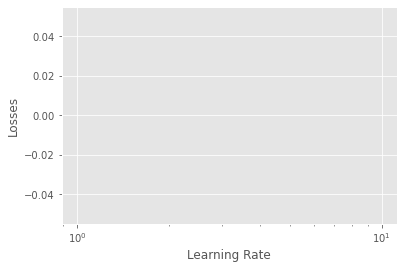

In [29]:
model, train_loss, train_acc, val_loss, val_acc = main(model_res, optimizer_ft, data_augmentation=True)

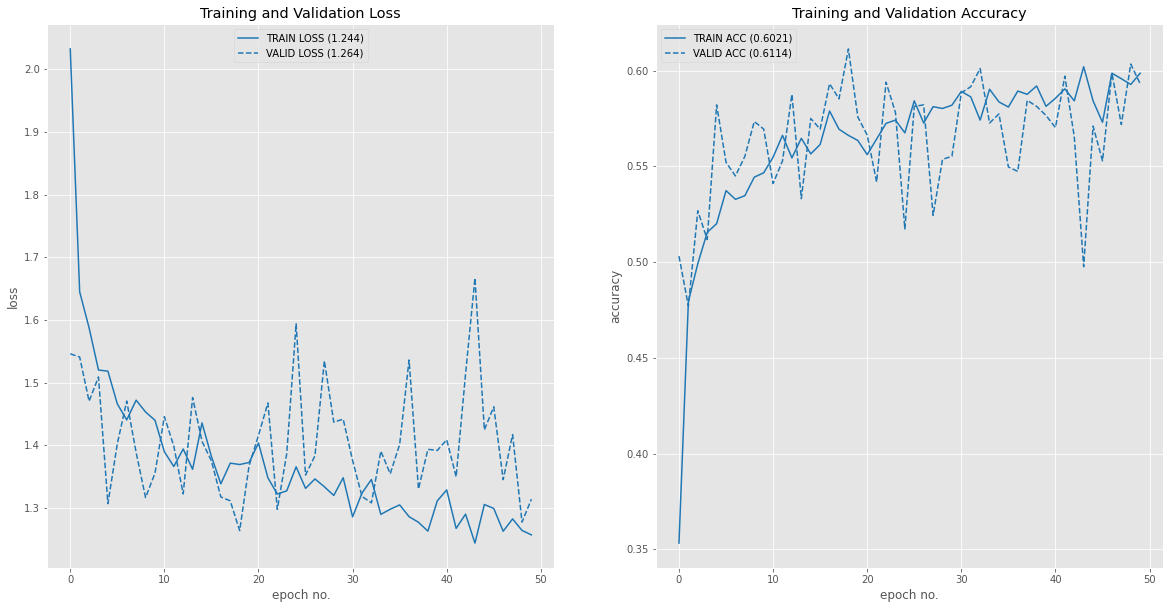

In [33]:
plot_loss_accuracy(train_loss=[train_loss], 
                   val_loss=[val_loss], 
                   train_acc=[train_acc], 
                   val_acc=[val_acc], 
                   colors=['blue'], 
                   loss_legend_loc='upper center', 
                   acc_legend_loc='upper left')

In [31]:
def prediction_test(model, device, batch_input):
    
    # send model to cpu/cuda according to your system configuration
    model.to(device)
    
    # it is important to do model.eval() before prediction
    model.eval()

    data = batch_input.to(device)

    output = model(data)

    # Score to probability using softmax
    prob = F.softmax(output, dim=1)

    # get the max probability
    pred_prob = prob.data.max(dim=1)[0]
    
    # get the index of the max probability
    pred_index = prob.data.max(dim=1)[1]
    
    return pred_index.cpu().numpy()

In [32]:
def get_sample_prediction_test(model, data_root, mean, std):
    batch_size = 10

    if torch.cuda.is_available():
        device = "cuda"
        num_workers = 8
    else:
        device = "cpu"
        num_workers = 2
        
        
    
    # transformed data
    test_dataset_trans = MyData(path=data_root, transform=image_common_transforms(mean, std))
    
    fname = test_dataset_trans.__filepath__()
    
    test_loader = torch.utils.data.DataLoader(test_dataset_trans, 
                                         batch_size=15,
                                         num_workers=4,
                                         shuffle=False)
     
    cls_final =[]
    for i in test_loader:
        cls = prediction_test(model, device, batch_input=i)          
        cls_final.append(cls)       
    
    return cls_final,fname
        
    

In [ ]:
m = model_res

m = load_model(m)

train_config = TrainingConfiguration()

test_data_path_real = train_config.data_root+ '/test/'

train_data_path = os.path.join(train_config.data_root, 'training')


mean, std = get_mean_std(train_data_path)


a,fname = get_sample_prediction_test(m, test_data_path_real, mean, std)

In [ ]:
class_label=flatten(a)
#class_label

In [ ]:
class_name=['bhaji',
 'chapati',
 'githeri',
 'kachumbari',
 'kukuchoma',
 'mandazi',
 'masalachips',
 'matoke',
 'mukimo',
 'nyamachoma',
 'pilau',
 'sukumawiki',
 'ugali']

In [ ]:
class_name_new = [class_name[k] for k in class_label]
#class_name_new

In [ ]:
np.savetxt("label_opencv.csv",class_name_new,delimiter=",", fmt='%s')
np.savetxt("fname_opencv.csv",fname,delimiter=",", fmt='%s')

## <font style="color:green">8. TensorBoard Dev Scalars Log Link [5 Points]</font>

Share your tensorboard scalars logs link in this section. You can also share (not mandatory) your GitHub link if you have pushed this project in GitHub. 

For example, [Find Project2 logs here](https://tensorboard.dev/experiment/kMJ4YU0wSNG0IkjrluQ5Dg/#scalars).

## <font style="color:green">9. Kaggle Profile Link [50 Points]</font>

Share your Kaggle profile link here with us so that we can give points for the competition score. 

You should have a minimum accuracy of `75%` on the test data to get all points. If accuracy is less than `70%`, you will not get any points for the section. 

**You must have to submit `submission.csv` (prediction for images in `test.csv`) in `Submit Predictions` tab in Kaggle to get any evaluation in this section.**